In [2]:
%matplotlib inline
from pylab import *
from numpy import *
import neuron
import pyNN
from pyNN import neuron
from pyNN.standardmodels import electrodes, build_translations, StandardCurrentSource
from pyNN.parameters import ParameterSpace, Sequence
from pyNN.neuron import simulator
from pyNN.utility import get_simulator, normalized_filename
from pyNN.utility.plotting import Figure, Panel
from neuron import h
from quantities import mV,Hz

/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/pyNN/neuron/__init__.py:14: UserWarning: mpi4py not available
  warnings.warn("mpi4py not available")


In [3]:
amps = linspace(-5, 5, 10)
cell = neuron.Population(10, neuron.IF_curr_exp(v_thresh = -50.0, tau_refrac = 5.0, tau_m = 10.0))
for cell_id in arange(0,9):
    pulse = neuron.ACSource(start = 20.0, stop = 80.0, amplitude = amps[cell_id], offset = 0.1, frequency = 10, phase = 180.0)
    cell[cell_id].inject(pulse)

In [4]:
cell.record('v')

In [5]:
neuron.run(100.0)

100.00000000001417

In [6]:
vm = cell.get_data().segments[0].filter(name = "v")[0]

In [7]:
vm

AnalogSignal with 10 channels of length 4001; units mV; datatype float64 
name: 'v'
annotations: {'source_ids': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  'source_population': 'population0'}
sampling rate: 40.0
time: 0.0 to 100.025

In [8]:
neuron.end()

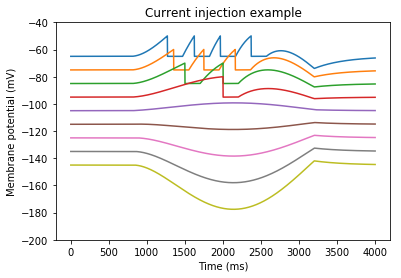

In [9]:
for cell_id in arange(0,9):
    plt.plot(vm[:,cell_id]-10*mV*cell_id)
plt.xlabel("Time (ms)")
plt.ylabel("Membrane potential (mV)")
plt.ylim(-200, -40)
plt.title("Current injection example");

In [10]:
vm[:,0]

AnalogSignal with 1 channels of length 4001; units mV; datatype float64 
name: 'v'
annotations: {'source_ids': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  'source_population': 'population0'}
sampling rate: 40.0
time: 0.0 to 100.025

In [11]:
import elephant as ep

In [12]:
from elephant.spike_train_generation import threshold_detection

In [13]:
trains = {}
for cell_id in arange(0,9):
    trains[cell_id] = threshold_detection(vm[:,cell_id], threshold=-50.01*mV, sign='above')

In [14]:
for train in trains.values():
    print(len(train))

4
3
2
1
0
0
0
0
0


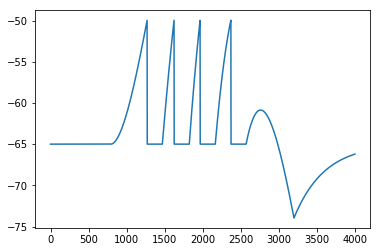

In [15]:
plt.plot(vm[:,0])

In [16]:
from elephant.spike_train_dissimilarity import victor_purpura_dist

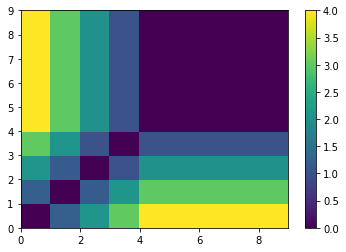

In [27]:
distance_matrix = victor_purpura_dist(trains.values(), q=array(20.0) * Hz)
plt.pcolor(distance_matrix)
plt.colorbar()

In [18]:
trains[0][0]

array(31.725) * ms

In [19]:
trains[8].dimensionality.simplified

Dimensionality({second: 1})

In [21]:
import neo
import quantities as pq
for cell_id in arange(0,9):
    print(pq.Quantity(1, "s").dimensionality.simplified,trains[cell_id].dimensionality.simplified,isinstance(trains[8], (pq.quantity.Quantity, neo.core.SpikeTrain)))

s s True
s s True
s s True
s s True
s s True
s s True
s s True
s s True
s s True


In [22]:
isinstance(trains[8], (pq.quantity.Quantity, neo.core.SpikeTrain))

True

In [23]:
import neo

In [24]:
type(trains[0])

neo.core.spiketrain.SpikeTrain

In [28]:
cell = neuron.Population(10, neuron.IF_curr_exp(v_thresh = -50.0, tau_refrac = 5.0, tau_m = 10.0))

In [31]:
corrcoef([0,3,4],[1,-5,7])[0,1]

0.2401922307076307